# Notebook initialization

## Selecting best GPU to execute on

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = 3#min(zip(ids, ratios), key=lambda x: x[1])[0]

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

setGPU: Setting GPU to: 3


##  Global variables

In [2]:
# IPython extension to reload modules before executing user code.
# 'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")

In [3]:
# with open('simulation_id.txt', 'r') as f:
#     simulation_id = int(f.read())

#with open('simulation_id.txt', 'w') as f:
 #   f.write(str(simulation_id))

simulation_id = 6

In [4]:
weights_path = lambda name: '../weights/{}/{}/'.format(simulation_id, name)
figures_path = lambda name: 'figures/{}/{}/'.format(simulation_id, name)

In [5]:
print(simulation_id)
import datetime

6


## Seed initialization (for reproductible results)

In [6]:
# Setting the seed for NumPy generated random numbers
import numpy as np
np.random.seed(0)

# Setting the seed for Python random numbers
import random as rn
rn.seed(0)

# Setting the seed for TensorFlow random numbers
import tensorflow as tf
tf.set_random_seed(0)

#from keras.backend.tensorflow_backend import set_session
#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
#set_session(tf.Session(config=config))

# Importing packages

## User defined packages

In [7]:
from data_utils import *
from keras_utils import plot_layerwise_angle_deviation_curves, LayerwiseAngleDeviationCurves, LearningRateMonitor, TerminateOnBaseline, get_kernel_layer_names
from models import VGG16_beta

Using TensorFlow backend.


## Other packages

In [8]:
from keras import optimizers
from keras import callbacks
from keras.models import clone_model
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from collections import defaultdict
import scipy
import matplotlib.pyplot as plt
import pathlib
import pickle
from layca_optimizers import SGD

# Initialization

In [9]:
num_classes = 10

In [10]:
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

# Evaluation

In [11]:
# Simply loading both the initial and finals weights of our models

models = [

     ('vgg16_sgd_0', VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0)),
     ('vgg16_sgd_1', VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0)),
     ('vgg16_sgd_2', VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0)),
     
     ('vgg16_wdecay_0', VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001)),
     ('vgg16_wdecay_1', VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001)),
     ('vgg16_wdecay_2', VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001)),    
     
     ('vgg16_layca_0', VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0)),
     ('vgg16_layca_1', VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0)),
     ('vgg16_layca_2', VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0))
]

In [12]:
for name, model in models:
    model.load_weights(weights_path(name) + 'final/weights-final.hdf5') 

In [13]:
for name, model in models:
    sgd = SGD(lr=0.001, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('{} : test accuracy: {}\n'.format(name, scores[1]))

10000/10000 [==============================] - 5s 534us/step
vgg16_sgd_0 : test accuracy: 0.6427

10000/10000 [==============================] - 4s 428us/step
vgg16_sgd_1 : test accuracy: 0.7531

10000/10000 [==============================] - 4s 431us/step
vgg16_sgd_2 : test accuracy: 0.8364

10000/10000 [==============================] - 5s 468us/step
vgg16_wdecay_0 : test accuracy: 0.6591

10000/10000 [==============================] - 5s 475us/step
vgg16_wdecay_1 : test accuracy: 0.7388

10000/10000 [==============================] - 5s 480us/step
vgg16_wdecay_2 : test accuracy: 0.864

10000/10000 [==============================] - 5s 458us/step
vgg16_layca_0 : test accuracy: 0.6488

10000/10000 [==============================] - 5s 461us/step
vgg16_layca_1 : test accuracy: 0.7404

10000/10000 [==============================] - 5s 467us/step
vgg16_layca_2 : test accuracy: 0.8497



# Model parameters and learning curves

In [84]:
pathlib.Path('cosine').mkdir(parents=True, exist_ok=True)

In [81]:
# https://keras.io/visualization/
import matplotlib.pyplot as plt

def plot_history(ax, name, cosine, lrates):
    
    # Plot training & validation accuracy values
    plot_layerwise_angle_deviation_curves(cosine, ax)
    ax.set_title("Model angular deviation")
    
#     ax2 = ax.twinx()
    
#     ax2.set_ylabel('Learning rate')
#     lns3 = ax2.plot(lrates, label='learning rate', color='green', ls='--')
    
#     lns = lns1+lns2+lns3
#     labs = [l.get_label() for l in lns]
#     ax.legend(lns, labs, loc='upper left')
    
    ax.legend(ncol=2, loc='best')
    ax.grid()
    

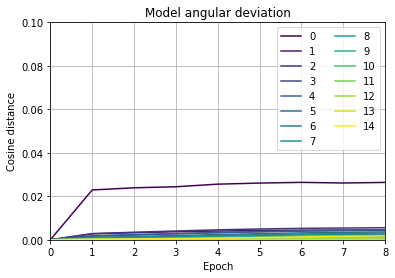

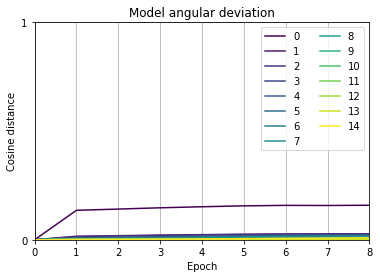

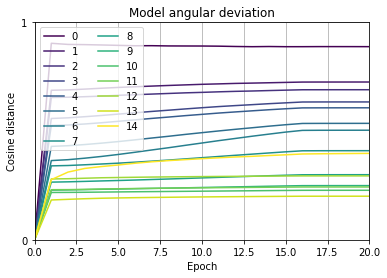

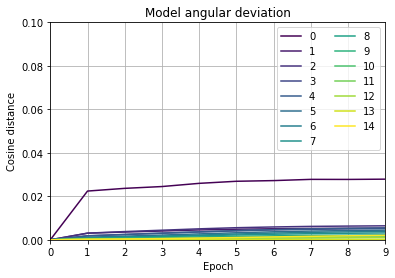

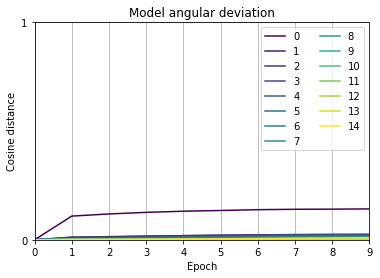

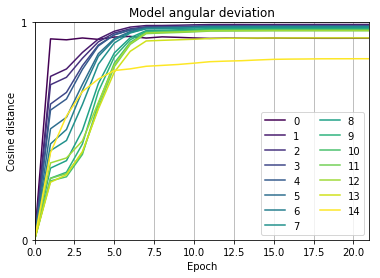

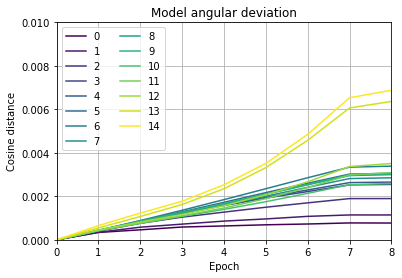

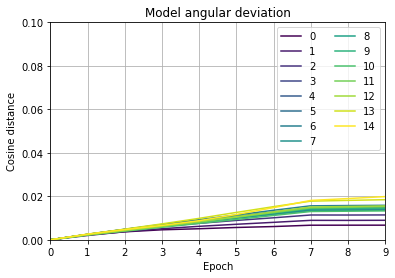

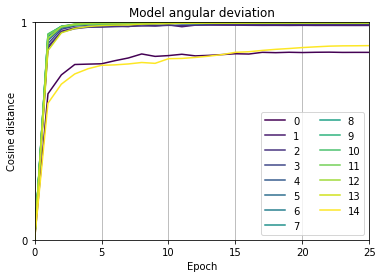

In [85]:
import pprint

for name, model in models:#, 'wdecay', 'layca']:
#     with open('{}/parameters.pickle'.format(weights_path(name)), 'rb') as handle:
#         parameters = pickle.load(handle)
#         print('{}\n'.format(name))
#         pprint.pprint(parameters, width=1)
    fig, ax = plt.subplots(nrows=1, ncols=1)
     
    with open('{}cosines.pickle'.format(weights_path(name)), 'rb') as handle:
        cosine = pickle.load(handle)

    with open('{}/lrates.pickle'.format(weights_path(name)), 'rb') as handle:
        lrates = pickle.load(handle)

        plot_history(ax, name, cosine, lrates)    

    #fig.tight_layout()
    fig.savefig('cosine/' + name + '.png', dpi=100)
    